In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils.reparam_module import ReparamModule

In [64]:
from utils import *
config = {
    'dataset': 'yelp-small-noise-50',
    'model': 'MetaModel7',
}
sub_model = 'SASRec'
dataset = 'yelp-small'

config = load_config(config)
dataset_list = prepare_datasets(config)
config['model']['sub_model'] = sub_model
model = prepare_model(config, dataset_list)
model._init_model(dataset_list[0])
device = model.device
state_dict_path = {
    'beauty': {
        'SASRec': 'saved/MetaModel7/amazon-beauty-noise-50/2024-02-01-00-51-08-316785.ckpt',
    },
    'sport': {
        'SASRec': 'saved/MetaModel7/amazon-sport-noise-50/2024-02-01-10-12-35-430957.ckpt',
    },
    'toy': {
        'SASRec': 'saved/MetaModel7/amazon-toys-noise-50/2024-01-31-23-58-49-529787.ckpt',
        'GRU4Rec': 'saved/MetaModel7/amazon-toys-noise-50/2024-02-01-13-08-11-946162.ckpt',
        'GNN': 'saved/MetaModel7/amazon-toys-noise-50/2024-02-01-15-33-58-403521.ckpt',
        'CL4SRec': 'saved/MetaModel7/amazon-toys-noise-50/2024-02-01-18-02-42-186590.ckpt',
    },
    'yelp-small': {
        'SASRec': 'saved/MetaModel7/yelp-small-noise-50/2024-02-01-14-58-24-736826.ckpt',
    }
}
model.load_checkpoint(state_dict_path[dataset][sub_model])
model = model.to('cuda:' + str(model.device))
if sub_model == 'GNN':
    model.sub_model.query_encoder.norm_adj = model.sub_model.query_encoder.norm_adj.to('cuda:' + str(model.device))

In [65]:
loader = model.dataset_list[0].get_loader(shuffle=False)

In [66]:
loss_weight_list = []
logits_list = []
model.eval()
for batch in loader:
    query = model.sub_model.forward(batch, need_pooling=False)
    logits = model.meta_module(query)
    logits_list.append(logits.detach().cpu())
    weight = F.gumbel_softmax(logits, torch.clip(model.tau, min=1), dim=-1)[..., 0]
    mask = batch['user_id'] == 0
    weight = weight.masked_fill(mask.unsqueeze(-1), 1)
    pad_mask = batch['item_id'] == 0
    weight = weight.masked_fill(pad_mask, 0)
    loss_weight_list.append(weight.detach().cpu())
loss_weight = torch.cat(loss_weight_list)
logits = torch.cat(logits_list)

In [67]:
torch.save(loss_weight, f'paper/loss_weight_{sub_model}_{dataset}.pth')
torch.save([logits, model.tau.item()], f'paper/logits_{sub_model}_{dataset}.pth')

# Analyze

In [16]:
sub_model_list = ['GRU4Rec', 'SASRec', 'GNN', 'CL4SRec']
mask = (model.dataset_list[0].data[0] != 0).cpu() # select meaningful points to compare
selected_idx = torch.randperm(mask.sum().item())[:25]

In [17]:
data = []
for model_name in sub_model_list:
    loss_weight = torch.load(f'paper/loss_weight_{model_name}_toys.pth')
    matrix = loss_weight[mask][selected_idx][:, :25]
    data.append(matrix)

/tmp/ipykernel_28527/4010822665.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


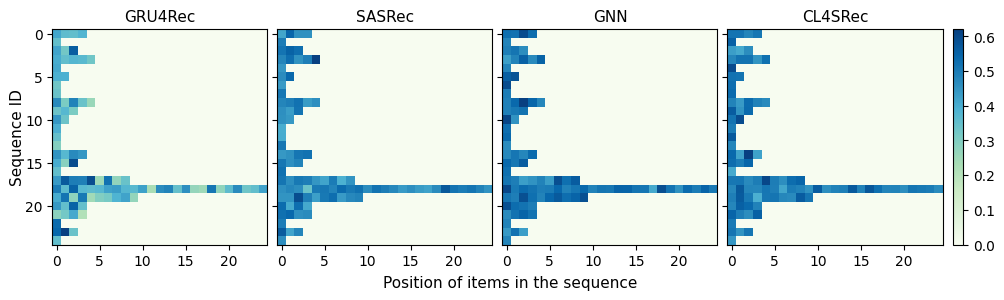

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# 创建画布和ImageGrid布局
fig = plt.figure(figsize=(10, 6))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.1, cbar_mode='single')

# 绘制热力图和设置标题
for idx, img in enumerate(data):
    im = grid[idx].imshow(img, cmap='GnBu')
    grid[idx].set_title(sub_model_list[idx], fontdict={'size': 11})

# 创建共享colorbar
cbar = grid.cbar_axes[0].colorbar(im)

fig.text(0.5, 0.25, 'Position of items in the sequence', ha='center', fontdict={'size': 11})
fig.text(0, 0.5, 'Sequence ID', va='center', rotation='vertical', fontdict={'size': 11})
# 调整子图布局
plt.tight_layout()

plt.savefig(f'figure/heat_map_all.pdf', dpi=600, bbox_inches = 'tight')
# 显示图形
plt.show()

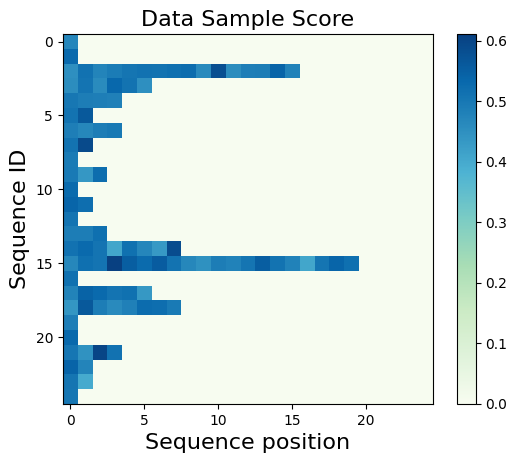

In [74]:
import numpy as np
import matplotlib.pyplot as plt

model_idx = 3
loss_weight = torch.load(f'paper/loss_weight_{sub_model_list[model_idx]}_toys.pth')
matrix = loss_weight[mask][selected_idx][:, :25]
plt.imshow(matrix, cmap='GnBu', interpolation='nearest')
plt.colorbar()
plt.title('Data Sample Score', fontdict={'size': 16})
plt.xlabel('Sequence position', fontdict={'size': 16})
plt.ylabel('Sequence ID', fontdict={'size': 16})
plt.savefig(f'figure/head_map_{sub_model_list[model_idx]}.pdf', dpi=600)
plt.show()